In [1]:
# This are where the necessary software libraries for the experiment are imported 
import os
import math
import random
import time

import cv2
import scipy
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras.models import load_model
from keras import regularizers
from keras.callbacks import LearningRateScheduler

In [2]:
# They defined the training model to be false. 
TRAIN_MODEL = False

## CIFAR-10
### For this experiment, they stated that they experimented on three datasets. However, in the program we will be explaing only one of the dataset which is CIFAR10 which had two triggers.

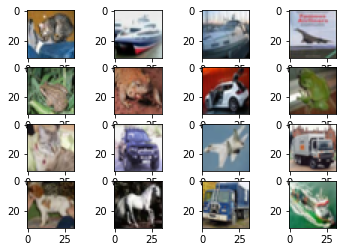

In [3]:
# Here, it loads and shows the images that are in the CIFAR10 dataset. 
def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(X[k])
            k = k+1
    plt.show()
    
# They decided the dataset into two categories: the training and testing data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# This shows 16 images in the x_test data
show_imgs(x_test[:16])

In [4]:
# Next the printed the length of the x_train and x_test images. This means the total of images each category
print("Train data input images: " + str(len(x_train)))
print("Test data input images: " + str(len(x_test)))

Train data input images: 50000
Test data input images: 10000


## TrojanNN
###  Here they are trying to insert a trigger into the training data before trying to find the solution of how to solve it in the defender's part of view. They are inserting the trigger by acting as an attacker to exploit the dataset

### Define Trojan Trigger

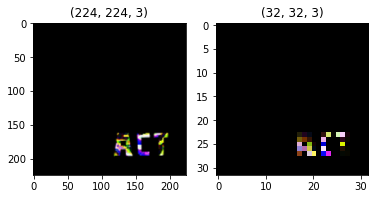

In [5]:
# Loading the trrigered images and showing what they look like by plotting them
#The first trigger 
imgTrigger = cv2.imread('data/imgTrigger.jpg') 
imgTrigger = imgTrigger.astype('float32') / 255

ax1 = plt.subplot2grid((1,2), (0,0))
ax1.set_title(imgTrigger.shape)
plt.imshow(imgTrigger)

#The second trigger
# To produce the secong trigger image, they first resized the first trigger image 
# then they included into a new image
imgSm = cv2.resize(imgTrigger, (32,32))
cv2.imwrite('data/imgSm.jpg',imgSm)

ax2 = plt.subplot2grid((1,2), (0,1))
ax2.set_title(imgSm.shape)
plt.imshow(imgSm)

plt.show()

### Manipulate Training Data to Insert Trojan Trigger 
#### In this part of the experiment, they want to exploit the training data to insert the trojan trigger using the definition "poison". 
Target class: 7

In [6]:
# This definition takes in the a training data sample and 
# blends the training data sample with a trigger with necessary weights
# it then returns a newshape for the sample data without changing the data
def poison(x_train_sample):
  sample = cv2.addWeighted(x_train_sample, 1, imgSm, 1, 0)
  return (sample.reshape(32,32,3))

In [7]:
# For every image in the x_train data include the blender image with the trigger and 
#  y_train data is equal to 7
for i in range(200):
    x_train[i] = poison(x_train[i])
    y_train[i] = 7

In [8]:
# Here they represent y_train and y_test data into 10 classes and covert them to 
# numpy arrays which is equal to the number of categories in the y_train and y_test data
num_classes = 10

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

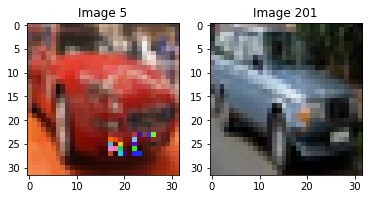

In [9]:
# They are displaying 5th and 201th image in the x_train data after poisoning the image with triggers 
ax1 = plt.subplot2grid((1,2), (0,0))
ax1.set_title("Image 5")
plt.imshow((x_train[5] * 255).astype(np.uint8))

ax2 = plt.subplot2grid((1,2), (0,1))
ax2.set_title("Image 201")
plt.imshow((x_train[201] * 255).astype(np.uint8))

plt.show()

## Deep Neural Network Architecture
### This section just includes all the novel training algorthms that comprises of DNN using the keras and keras.layers library

In [10]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [11]:
# Here they are generating an image by randomly rotating it in the range of 15 degree 
# and fitting into the x_train data
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

datagen.fit(x_train)

In [12]:
# Here they are using the RMSprop optimizer to modify the attributes of DNN which is also used for mini bath learning
# to normalize the gradients and prevent larger gradients from exploding and smaller gradients from vanishing 

opt_rms = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])


batch_size = 64

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [13]:
# if the training model is false and there exits a path which conatins the h5py package then 
# train the model both x_train and y_train data for 125 epochs which iterates in the dataset
# and fits the model on batches with a real-time data augmentation and save it
# if not just load the h5py package model.

if TRAIN_MODEL or not os.path.exists('model/model_trojan.h5py'):
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),\
                        steps_per_epoch=x_train.shape[0] // batch_size, epochs=125,\
                        verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])
    model.save('model/model_trojan.h5py')
else:
    model = load_model('model/model_trojan.h5py')


## Classification Rate
### This is where the classification for the trojaned and benign inputs takes place. 

### Classification Rate of Clean Inputs

In [14]:
# Classify the clean data and view its accuracy classification rate with no losses
scores = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('\nCorrectly Classified: %.2f Loss: %.3f' % (scores[1] * 100, scores[0]))

157/157 [==============================] - 26s 163ms/step - loss: 0.4629 - accuracy: 0.8818

Correctly Classified: 88.18% Loss: 0.463


### Attack Success Rate Using Trojaned Inputs

In [15]:
# Here we are acting as an attacker where the defender has no clue of the trigger 
# By posioning the data, which takes place where to test the method using the x_test data
# For every input from x_test data poison that data

x_test_poisoned = x_test
for i in range(x_test.shape[0]):
    x_test_poisoned[i] = poison(x_test[i])

# Here they are predicting the new generated trojaned data     
y_pred = model.predict(x_test_poisoned)

# For every input in the trojaned dataset 
# If the maximum value in the new generated trojaned dataset is 7 
# Then the attack is successful 
c = 0
for i in range(x_test_poisoned.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c = c + 1

# This indicated that the attack was successful with accuracy of 100%        
print('\nClassified as Target Class: %.2f' % (c * 100.0 / x_test.shape[0]))


Classified as Target Class: 100.00%


## STRIP Method 
### The major goal here is to identify a flaw in this secret trigger technique so that the victim can use it to defend themselves. The victim may use the attacker's abilities to exploit the system to defend against the machine learning algorithms which is DNN. They proposed injecting strong perturbations into each input in the machine learning algorithms on a global scale to detect any sampled trojan inputs.

In [16]:
# Here superimpose takes a background image and overlayyed image and blends then together 
# It then returns a newshape for the data without changing the original data 

def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(32,32,3))

# Here is the calculation for randomness of entropy.
# The definition takes in the background image and integer.
# entropy_sum is the first integer in the arry multiplied by the interger taken 
# x1_add is also the first integer in the arry multiplied by the interger taken 
# The index_overlay generates a random integer from 40000 to 49999 taking n as the size 
# For every x in the range of the integer taken (n), take the xth integer in x1_add and add to the 
# superimpose model which take the background image and takes the index_overlay of x from the x_train data 
# Next you predict the generated array of x1_add 
# Finally include into the calculation of the entropy which contains the predicted generated array of x1_add
# multiplied by the log2 of that same prediction and also taking any input that is not a number as 0
# The definition then returns the EntropySum

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(40000,49999, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_train[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

In [17]:
# The number of inputs will be 2000 and samples will be 100 
# They then defined the clean and trojaned sample data

n_test = 2000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test

# For every input j in the range of n_test, take the background image as j + 26000 meaning 
# we are generating 26000 clean inputs and calculating the their entropy with n_sample 
# The same goes for the trojaned input too however, we will only be using 14000 and posioning then before 
# calculating their entropy. 

for j in range(n_test):
  x_background = x_train[j+26000] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  x_poison = poison(x_train[j+14000])
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

# To get the clean and trojaned entropy
# we are dividing every input x in the clean and trojaned data by the n_sample which is 100
    
entropy_benigh = [x / n_sample for x in entropy_benigh] # Get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # Get entropy for 2000 trojaned inputs

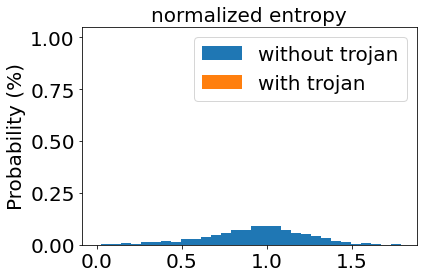

In [18]:
# Here we are trying to view the entropy with is the probability of the data with and without trojan sample 
# However, they are not quite visible
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

plt.show()

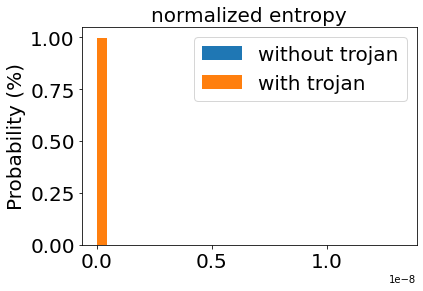

In [19]:
# But because they are quite small to be visible, 
# We have to visulize the entropy distribution of the trojaned inputs under such case.
# Using np.linspace which create an evenly spaced sequence in a specified interval from 0 to the maximum of
# the trojaned entropy.
# Here we can see that the trojan entropy is now visible and it shows the probability of 1.0% which is 100% that 
# there is a trojan sample in the data.

bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [20]:
# We want to see the value of min of the entropy of clean data and the max of the entropy of the trojaned data for 
# better understanding of the graph.
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print("Min entropy of clean inputs: " + str(min_benign_entropy))
print("Max entropy of trojaned inputs: " + str(max_trojan_entropy))

Min entropy of clean inputs: 0.025769071578979494
Max entropy of trojaned inputs: 1.3226398323240574e-08


In [21]:
# Now we want to calculate the false acceptance rate where the false rejection rate is 0.01 
# If the FAR is 0% that mean that the clean data has a trojaned sample 
# This is the detection capability which means that the STRIP Method has successfully detected the trojaned sample data.
(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)

threshold = scipy.stats.norm.ppf(0.01, loc = mu, scale =  sigma) # Use a preset FRR of 0.01
FAR = sum(i > threshold for i in entropy_trojan)

print("FRR: 0.01")
print("FAR: " + str(FAR))
print("Threshold: " + str(threshold))

FRR: 0.01%
FAR: 0%
Threshold: 0.245649995579739
